In [1]:
import os
import sys
# add /home/shiftpub/Dynamic_AMM as a path
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

In [2]:
import os
import sys
# add /home/shiftpub/Dynamic_AMM as a path
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

oracle = OracleSimulator(spread=1, sigma=1)
amm = AMM(fee_pool=True)
trader = Arbitrager(amm, oracle)

In [3]:
mkt_bids = []
mkt_asks = []
amm_bids = []
amm_asks = []
swap_infos = []


for _ in range(20):
    mkt_ask, mkt_bid = oracle.get_price()
    amm_ask, amm_bid = amm.get_price()
    mkt_bids.append(mkt_bid)
    mkt_asks.append(mkt_ask)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    
    swap_info = trader.swap()
    swap_infos.append(swap_info)
    oracle.next()
print(f"final_pnl: {trader.pnl}")
    

final_pnl: 3206.181088188663


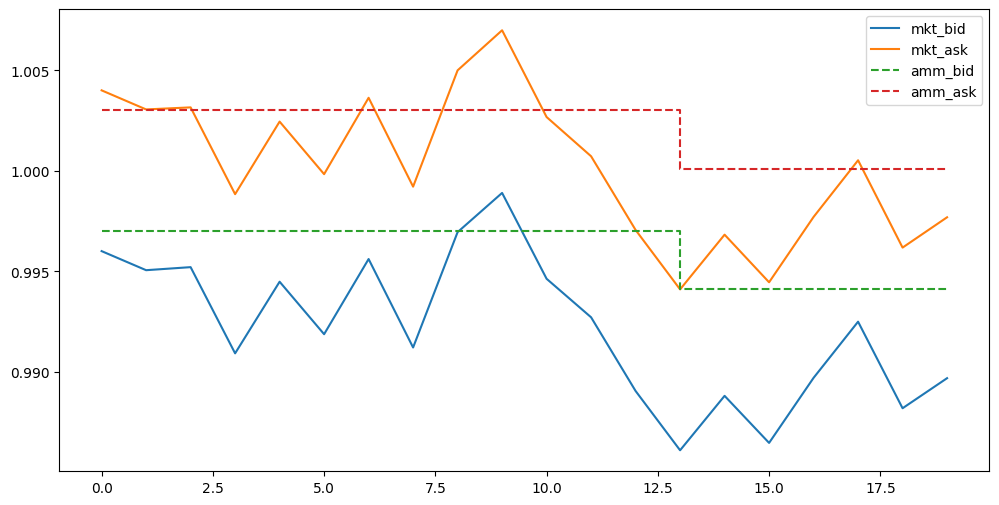

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(mkt_bids, label='mkt_bid')
plt.plot(mkt_asks, label='mkt_ask')
plt.step(range(len(amm_bids)), amm_bids, label='amm_bid', linestyle='--', where='pre')
plt.step(range(len(amm_asks)), amm_asks, label='amm_ask', linestyle='--', where='pre')
plt.legend()
plt.show()


In [5]:
from pprint import pprint
for idx, swap_info in enumerate(swap_infos):
    print(f'Round {idx}')
    pprint(swap_info)

Round 0
{'amm_ask': 1.0030090270812437,
 'amm_bid': 0.997,
 'amm_cost': 0,
 'asset_in': 0,
 'asset_out': 0,
 'current_pool_value': 1000000000,
 'fee_dollar_value': 0,
 'fee_pool': True,
 'fee_rate': 0.003,
 'impermanent_loss': 0,
 'initial_pool_value': 1000000000,
 'lr': 1000000,
 'ls': 1000000,
 'mid_r': 500,
 'mid_s': 500,
 'mkt_ask': 1.0040080160320641,
 'mkt_bid': 0.9960079840319361,
 'mkt_gain': 0,
 'net_profit': 0,
 'pnl': 0,
 'pre_lr': 1000000,
 'pre_ls': 1000000,
 'prev_amm_ask': 1.0030090270812437,
 'prev_amm_bid': 0.997,
 'spread': 1,
 'token_fee': 0,
 'token_in': 's',
 'token_out': 'r',
 'total_fee_dollar_value': 0,
 'total_number_trade': 0,
 'xr': 0,
 'xs': 0}
Round 1
{'amm_ask': 1.0030090270812437,
 'amm_bid': 0.997,
 'amm_cost': 0.0,
 'asset_in': 0,
 'asset_out': 0,
 'current_pool_value': 999199267.0780823,
 'fee_dollar_value': 0.0,
 'fee_pool': True,
 'fee_rate': 0.003,
 'impermanent_loss': 0.0,
 'initial_pool_value': 999199267.0780823,
 'lr': 1000000,
 'ls': 1000000,
 '

In [6]:
import pandas as pd

start_price=500
mu=0.06
dt=1/(252*6.5*60*60)
steps=int(60*60*6.5)
spread=0.005
fee_rate = 0.003
sigma = 0.4
iterations = 1000
    
amm = AMM(fee=fee_rate, fee_pool=False)
market = OracleSimulator(sigma=sigma,
                         mu=mu,
                         start_price=start_price,
                         steps=steps,
                         spread=spread,
                         dt=dt)

trader = Arbitrager(amm, market)
initial_pool_value = amm.lr * market.get_mid_price('r') + amm.ls * market.get_mid_price('s')
# Loop over market steps
for iter in range(iterations):
    record = []
    for _ in range(int(market.steps)):
        # Get trader observations
        swap_info = trader.swap()
        record.append(swap_info)
        market.next()
    trader.reset()
    if record[-1]['impermanent_loss'] > 0:
        # make recorder as dataframe
        record = pd.DataFrame(record)
        record.to_csv('positive_loss_record.csv')
        break
    
    


## check the xr sign

In [7]:
# select rows where xs and xr are not zero
transaction_record = record[(record['xs'] != 0) & (record['xr'] != 0)]
# select rows where prev_amm_ask < mkt_bid
transaction_record_amm_mkt = transaction_record[transaction_record['prev_amm_ask'] < transaction_record['mkt_bid']]
# test whether in this case the xr should be negative
print(f"xr negative when amm ask is lower than mkt bid: {(transaction_record_amm_mkt['xr']<0).sum()}")
print(f"total transaction: {transaction_record_amm_mkt.shape[0]}")

# select rows where prev_amm_bid > mkt_ask
transaction_record_mkt_amm = transaction_record[transaction_record['prev_amm_bid'] > transaction_record['mkt_ask']]
# test whether in this case the xr should be positive
print(f"xr positive when amm ask is higher than mkt bid: {(transaction_record_mkt_amm['xr']>0).sum()}")
print(f"total transaction: {transaction_record_mkt_amm.shape[0]}")

xr negative when amm ask is lower than mkt bid: 546
total transaction: 546
xr positive when amm ask is higher than mkt bid: 542
total transaction: 542


## check the alignment of two prices

In [8]:
# select rows where xs and xr are not zero
transaction_record = record[(record['xs'] != 0) & (record['xr'] != 0)]
transaction_record_amm_mkt = transaction_record[transaction_record['prev_amm_ask'] < transaction_record['mkt_bid']]
# check whether the amm ask equals to mkt bid
print(f"amm ask equals to mkt bid: {((transaction_record_amm_mkt['prev_amm_ask'] - transaction_record_amm_mkt['mkt_bid'])<1e16).sum()}")
print(f"total transaction: {transaction_record_amm_mkt.shape[0]}")

transaction_record_mkt_amm = transaction_record[transaction_record['prev_amm_bid'] > transaction_record['mkt_ask']]
# check whether the amm bid equals to mkt ask
print(f"amm bid equals to mkt ask: {((transaction_record_mkt_amm['prev_amm_bid'] - transaction_record_mkt_amm['mkt_ask'])<1e16).sum()}")
print(f"total transaction: {transaction_record_mkt_amm.shape[0]}")


amm ask equals to mkt bid: 546
total transaction: 546
amm bid equals to mkt ask: 542
total transaction: 542


# check the fee, impermanent loss, and net profit

In [9]:
import numpy as np

# Select rows where xs and xr are not zero
record['prev_fee'] = record['total_fee_dollar_value'].shift(1)
transaction_record = record[(record['xs'] == 0) & (record['xr'] == 0)][1:]

# Check if the fee is not changing
fee_not_changing = np.isclose(transaction_record['total_fee_dollar_value'], transaction_record['prev_fee'], atol=1e-6)
print(f"Fee not changing: {fee_not_changing.sum()}")
print(f"Total transactions checked: {transaction_record.shape[0]}")

# Check if the current pool value is correctly calculated
current_pool_value_correct = np.isclose(record['mid_r'] * record['lr'] + record['mid_s'] * record['ls'], record['current_pool_value'], atol=1e-6)
print(f"Current pool value correctly calculated: {current_pool_value_correct.sum()}")

# Check if the initial pool value is correctly calculated
initial_pool_value_correct = np.isclose(record['mid_r'] * 1000000 + record['mid_s'] * 1000000, record['initial_pool_value'], atol=1e-6)
print(f"Initial pool value correctly calculated: {initial_pool_value_correct.sum()}")

# Check if the impermanent loss is correctly calculated
impermanent_loss_correct = np.isclose(record['impermanent_loss'], record['current_pool_value'] - record['initial_pool_value'], atol=1e-6)
print(f"Impermanent loss correctly calculated: {impermanent_loss_correct.sum()}")

# check if the net profit is the sum of the total_fee_dollar_value and the impermanent_loss
net_profit_correct = np.isclose(record['net_profit'], record['total_fee_dollar_value'] + record['impermanent_loss'], atol=1e-6)
print(f"Net profit correctly calculated: {net_profit_correct.sum()}")


# Summary count of total transactions
print(f"Total transactions: {record.shape[0]}")


Fee not changing: 22311
Total transactions checked: 22311
Current pool value correctly calculated: 23400
Initial pool value correctly calculated: 23400
Impermanent loss correctly calculated: 23400
Net profit correctly calculated: 23400
Total transactions: 23400


In [10]:
print(f"current_pool_value: {997008.2936108732 * 501.4798212189421 + 1003000.683553285 * 499.9936850298152}")

current_pool_value: 1001473548.6910137


In [11]:
print(f"initial_pool_value: {1000000 * 501.4798212189421 + 1000000 * 499.9936850298152}")

initial_pool_value: 1001473506.2487574


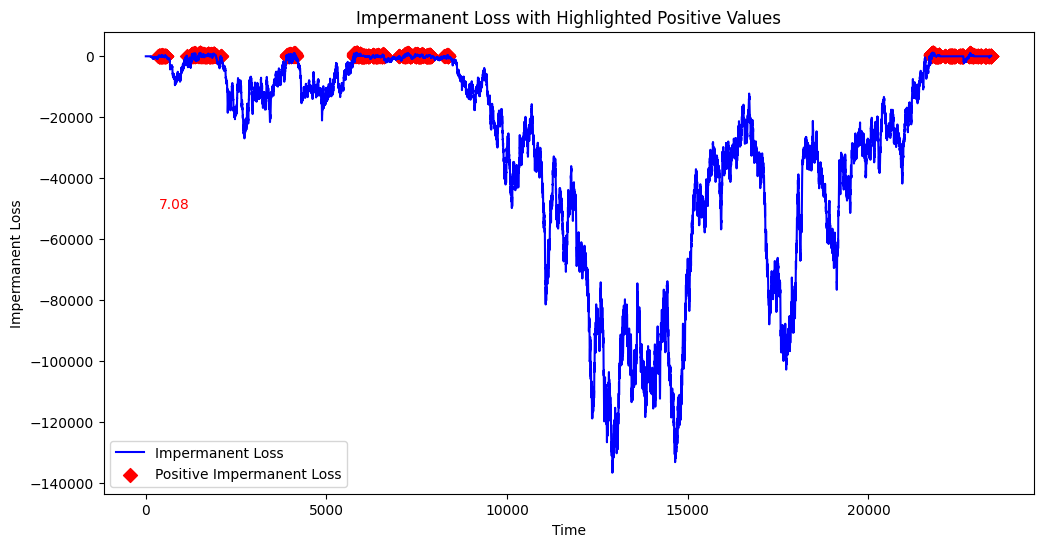

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

record = pd.read_csv('/home/shiftpub/Dynamic_AMM/env/positive_loss_record.csv')

# Plot the impermanent loss
plt.figure(figsize=(12, 6))
plt.plot(record['impermanent_loss'], label='Impermanent Loss', color='blue')

# Find positive impermanent loss points
positive_impermanent_loss = record[record['impermanent_loss'] > 0]

# Highlight positive impermanent loss points with larger, distinctive markers
plt.scatter(positive_impermanent_loss.index, positive_impermanent_loss['impermanent_loss'], 
            color='red', s=50, marker='D', label='Positive Impermanent Loss')

# Annotate the first positive impermanent loss point
first_positive_index = positive_impermanent_loss.index[0]
first_positive_value = positive_impermanent_loss['impermanent_loss'].iloc[0]

plt.annotate(f'{first_positive_value:.2f}', 
             xy=(first_positive_index, first_positive_value), 
             xytext=(first_positive_index, first_positive_value - 50000),  # Adjust offset as needed
             fontsize=10, color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Impermanent Loss')
plt.title('Impermanent Loss with Highlighted Positive Values')
plt.legend()

plt.show()


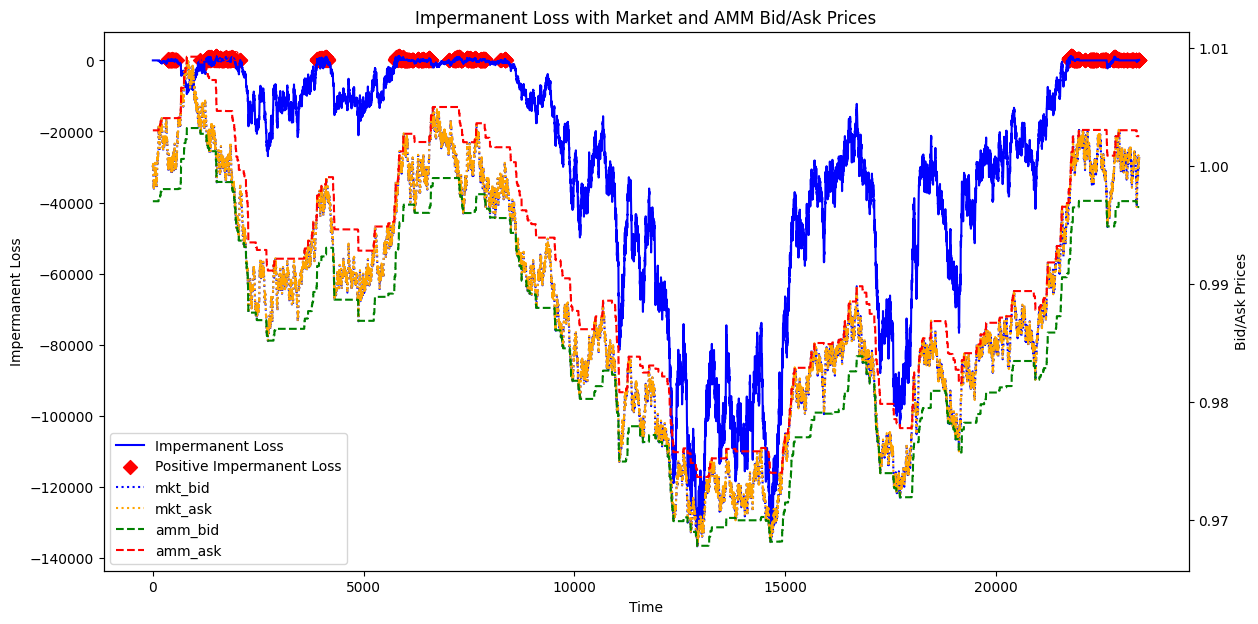

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create the figure and primary y-axis for impermanent loss
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot impermanent loss on the primary y-axis
ax1.plot(record['impermanent_loss'], label='Impermanent Loss', color='blue')
positive_impermanent_loss = record[record['impermanent_loss'] > 0]
ax1.scatter(positive_impermanent_loss.index, positive_impermanent_loss['impermanent_loss'], 
            color='red', s=50, marker='D', label='Positive Impermanent Loss')

# Annotate the first positive impermanent loss point
first_positive_index = positive_impermanent_loss.index[0]
first_positive_value = positive_impermanent_loss['impermanent_loss'].iloc[0]
ax1.annotate(f'{first_positive_value:.2f}', 
             xy=(first_positive_index, first_positive_value), 
             xytext=(first_positive_index+1000, first_positive_value),  # Adjust as needed
             fontsize=10, color='red')

# Labels for primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Impermanent Loss')
ax1.set_title('Impermanent Loss with Market and AMM Bid/Ask Prices')
# ax1.legend(loc='lower left')

# Create a secondary y-axis for bid/ask prices
ax2 = ax1.twinx()
ax2.plot(record['mkt_bid'], label='mkt_bid', color='blue', linestyle='dotted')
ax2.plot(record['mkt_ask'], label='mkt_ask', color='orange', linestyle='dotted')
ax2.step(range(len(record['amm_bid'])), record['amm_bid'], label='amm_bid', linestyle='--', color='green', where='pre')
ax2.step(range(len(record['amm_ask'])), record['amm_ask'], label='amm_ask', linestyle='--', color='red', where='pre')

# Labels and legend for secondary y-axis
ax2.set_ylabel('Bid/Ask Prices')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')

plt.show()


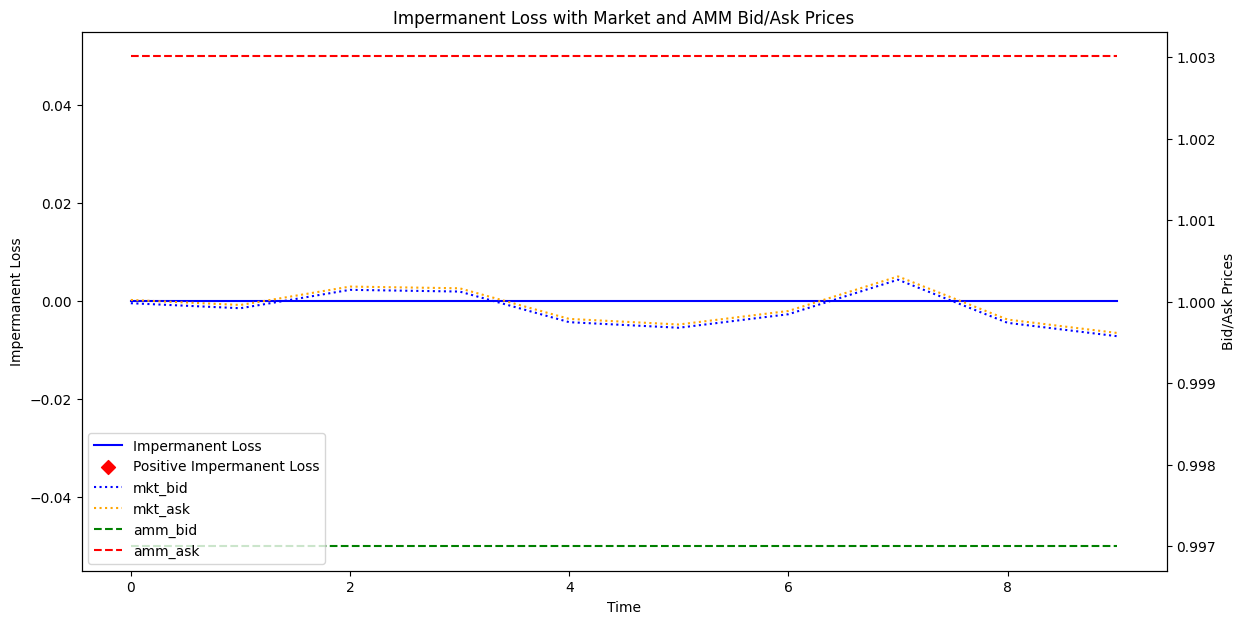

In [14]:
import numpy as np
import matplotlib.pyplot as plt

record = record[:10]

# Create the figure and primary y-axis for impermanent loss
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot impermanent loss on the primary y-axis
ax1.plot(record['impermanent_loss'], label='Impermanent Loss', color='blue')
positive_impermanent_loss = record[record['impermanent_loss'] > 0]
ax1.scatter(positive_impermanent_loss.index, positive_impermanent_loss['impermanent_loss'], 
            color='red', s=50, marker='D', label='Positive Impermanent Loss')

# Annotate the first positive impermanent loss point
# first_positive_index = positive_impermanent_loss.index[0]
# first_positive_value = positive_impermanent_loss['impermanent_loss'].iloc[0]
# ax1.annotate(f'{first_positive_value:.2f}', 
#              xy=(first_positive_index, first_positive_value), 
#              xytext=(first_positive_index+1000, first_positive_value),  # Adjust as needed
#              fontsize=10, color='red')

# Labels for primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Impermanent Loss')
ax1.set_title('Impermanent Loss with Market and AMM Bid/Ask Prices')
# ax1.legend(loc='lower left')

# Create a secondary y-axis for bid/ask prices
ax2 = ax1.twinx()
ax2.plot(record['mkt_bid'], label='mkt_bid', color='blue', linestyle='dotted')
ax2.plot(record['mkt_ask'], label='mkt_ask', color='orange', linestyle='dotted')
ax2.step(range(len(record['amm_bid'])), record['amm_bid'], label='amm_bid', linestyle='--', color='green', where='pre')
ax2.step(range(len(record['amm_ask'])), record['amm_ask'], label='amm_ask', linestyle='--', color='red', where='pre')

# Labels and legend for secondary y-axis
ax2.set_ylabel('Bid/Ask Prices')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')

plt.show()


In [15]:
print(record.iloc[0])

Unnamed: 0                           0
xs                                 0.0
xr                                 0.0
pre_ls                       1000000.0
pre_lr                       1000000.0
ls                           1000000.0
lr                           1000000.0
token_fee                          0.0
pnl                                0.0
fee_dollar_value                   0.0
total_fee_dollar_value             0.0
mkt_gain                           0.0
amm_cost                           0.0
initial_pool_value        1000000000.0
current_pool_value        1000000000.0
impermanent_loss                   0.0
net_profit                         0.0
total_number_trade                   0
token_in                             s
token_out                            r
asset_in                           0.0
asset_out                          0.0
mkt_ask                        1.00002
mkt_bid                        0.99998
prev_amm_ask                  1.003009
prev_amm_bid             

In [16]:
print(999563.6538614327 * 1000436.5366196356)

1000000000000.0


In [17]:
501.90687821430606

501.90687821430606

In [18]:
501.9029510921559

501.9029510921559

In [19]:
initial = 1000000*501.90687821430606 + 1000000*501.9029510921559
end = 999563.6538614327 * 501.90687821430606 + 1000436.5366196356 * 501.9029510921559
print(end - initial)

93.88942575454712


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("/home/shiftpub/Dynamic_AMM/env/positive_loss_record.csv")

# Identify the row index where the impermanent loss is positive
positive_loss_idx = df[df['impermanent_loss'] > 0].index[0]

# Select specific rows by index
tmp = df.iloc[[0, positive_loss_idx - 1, positive_loss_idx]].copy()

# Set the 'time_stamp' values using .loc to avoid the warning
tmp.loc[:, 'time_stamp'] = ['t0', 'T-1', 'T']

# Print impermanent loss to verify
print(tmp['impermanent_loss'])


0       0.000000
350   -91.685024
351     7.084382
Name: impermanent_loss, dtype: float64


In [22]:
print(f"lr at t0: {tmp['lr'].iloc[0]} | lr at T-1: {tmp['lr'].iloc[1]} | lr at T: {tmp['lr'].iloc[2]}")
print(f"ls at t0: {tmp['ls'].iloc[0]} | ls at T-1: {tmp['ls'].iloc[1]} | ls at T: {tmp['ls'].iloc[2]}")
print(f"mid_r at t0: {tmp['mid_r'].iloc[0]} | mid_r at T-1: {tmp['mid_r'].iloc[1]} | mid_r at T: {tmp['mid_r'].iloc[2]}")
print(f"mid_s at t0: {tmp['mid_s'].iloc[0]} | mid_s at T-1: {tmp['mid_s'].iloc[1]} | mid_s at T: {tmp['mid_s'].iloc[2]}")
print(f"impermanent loss at t0: {tmp['impermanent_loss'].iloc[0]} | impermanent loss at T-1: {tmp['impermanent_loss'].iloc[1]} | impermanent loss at T: {tmp['impermanent_loss'].iloc[2]}")


lr at t0: 1000000.0 | lr at T-1: 999484.2801260044 | lr at T: 999484.2801260044
ls at t0: 1000000.0 | ls at T-1: 1000515.9859782192 | ls at T: 1000515.9859782192
mid_r at t0: 500.0 | mid_r at T-1: 500.087231405347 | mid_r at T: 500.0705025885495
mid_s at t0: 500.0 | mid_s at T-1: 499.6516374975401 | mid_s at T: 499.8263360873128
impermanent loss at t0: 0.0 | impermanent loss at T-1: -91.68502414226532 | impermanent loss at T: 7.084381818771362


In [41]:
u1 = (tmp['mid_r'].iloc[1]/tmp['mid_s'].iloc[1]) / (tmp['mid_r'].iloc[0]/tmp['mid_s'].iloc[0])
print(f"u1 : {u1}")
u2 = (tmp['mid_r'].iloc[2]/tmp['mid_s'].iloc[2]) / (tmp['mid_r'].iloc[1]/tmp['mid_s'].iloc[1])
print(f"u2 : {u2}")

numerator = 1-np.sqrt(u1 * (1-tmp['fee_rate'].iloc[1]))
denominator = np.sqrt(u1/(1-tmp['fee_rate'].iloc[1])) - u1
print(f"numerator: {numerator} | denominator: {denominator} | result = {numerator/denominator}")

u1 : 1.0008717952171406
u2 : 0.9996170413174518
numerator: 0.0010659782390584072 | denominator: 0.001068046067655315 | result = 0.9980639144138723


In [61]:
1.0005164919669367 / 1.0008717952171406

0.9996450062316654

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Explicitly set the values in 'time_stamp' column using .loc
tmp.loc[:, 'time_stamp'] = ['t0', 'T-1', 'T']
oracle_price_ratios2 = []
impermanent_losses2 = []
external_prices = []

# Store initial mid prices to reset after each iteration
initial_mid_r = tmp['mid_r'].iloc[-1]
initial_mid_s = tmp['mid_s'].iloc[-1]

# Constants to avoid recalculating in the loop
amm_ask = tmp['amm_ask'].iloc[2]
amm_bid = tmp['amm_bid'].iloc[2]

# Iterate over a range of price adjustments

# Adjust the mid price at the final timestamp by adding p and q
adjusted_mid_r = initial_mid_r * 0.9980639144138723

# Calculate the price ratio
price_ratio = adjusted_mid_r / adjusted_mid_s
initial_value = 1000000 * adjusted_mid_r + 1000000 * adjusted_mid_s

# Calculate impermanent loss based on the adjusted values
il = (adjusted_mid_r * tmp['lr'].iloc[2] + adjusted_mid_s * tmp['ls'].iloc[2]) - initial_value

# Append the oracle price ratio and calculated impermanent loss
oracle_price_ratios2.append(price_ratio)
impermanent_losses2.append(il)
external_prices.append((adjusted_mid_r, adjusted_mid_s))

print(f"ratio range: {min(oracle_price_ratios2)} - {max(oracle_price_ratios2)}")
print(f"amm ask bid range: {amm_bid} - {amm_ask}")



ratio range: 0.9980291513805419 - 1.0040443702408954
amm ask bid range: 0.9980291414833744 - 1.0040443713119038


break_even_price: 1.0005164919669367


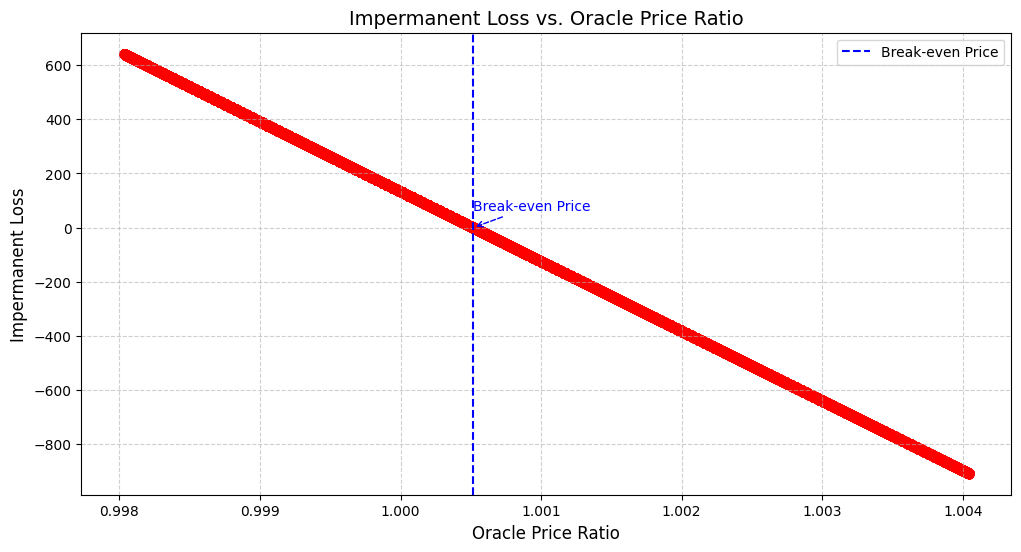

In [40]:
# Plotting the oracle price ratio against impermanent loss
plt.figure(figsize=(12, 6))
plt.scatter(oracle_price_ratios2, impermanent_losses2, color='red', alpha=0.7)

# Find the oracle price ratio where the impermanent loss closest to zero
break_even_price = oracle_price_ratios2[np.argmin(np.abs(impermanent_losses2))]
print(f"break_even_price: {break_even_price}")
plt.axvline(x=break_even_price, color='blue', linestyle='--', label='Break-even Price')

# Add an annotation for the break-even price with an offset to avoid overlap
plt.annotate(
    'Break-even Price', 
    xy=(break_even_price, 0), 
    xytext=(break_even_price, max(impermanent_losses2) * 0.1),
    arrowprops=dict(arrowstyle="->", color='blue', linestyle="--"),
    fontsize=10,
    color='blue'
)

# Set labels and title
plt.xlabel('Oracle Price Ratio', fontsize=12)
plt.ylabel('Impermanent Loss', fontsize=12)
plt.title('Impermanent Loss vs. Oracle Price Ratio', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend()
plt.show()


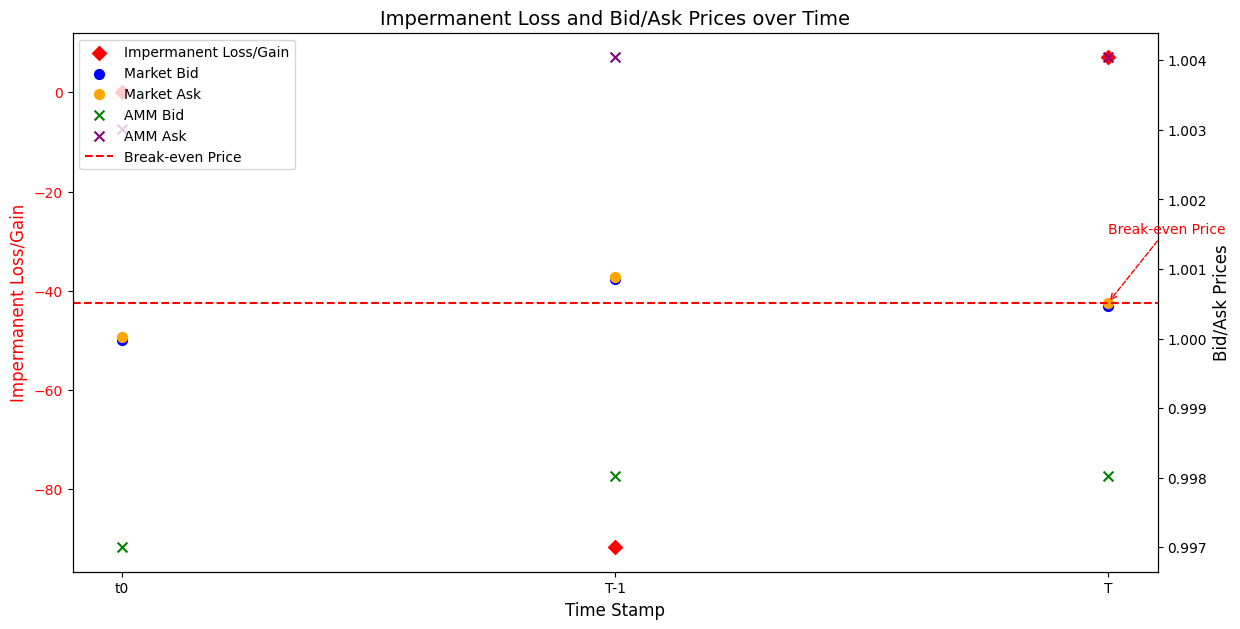

In [35]:
import matplotlib.pyplot as plt

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot impermanent loss on the primary y-axis
ax1.scatter(tmp['time_stamp'], tmp['impermanent_loss'], color='red', s=50, marker='D', label='Impermanent Loss/Gain')
ax1.set_ylabel('Impermanent Loss/Gain', color='red', fontsize=12)
ax1.set_xlabel('Time Stamp', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')

# Create a secondary y-axis for bid/ask prices
ax2 = ax1.twinx()
ax2.scatter(tmp['time_stamp'], tmp['mkt_bid'], color='blue', s=50, marker='o', label='Market Bid')
ax2.scatter(tmp['time_stamp'], tmp['mkt_ask'], color='orange', s=50, marker='o', label='Market Ask')
ax2.scatter(tmp['time_stamp'], tmp['amm_bid'], color='green', s=50, marker='x', label='AMM Bid')
ax2.scatter(tmp['time_stamp'], tmp['amm_ask'], color='purple', s=50, marker='x', label='AMM Ask')

# Add a horizontal line for the break-even price
break_even_price = oracle_price_ratios2[np.argmin(np.abs(impermanent_losses2))]
ax2.axhline(y=break_even_price, color='red', linestyle='--', label='Break-even Price')

# Add an annotation for the break-even price with an offset to avoid overlap
ax2.annotate(
    'Break-even Price',
    xy=(tmp['time_stamp'].iloc[-1], break_even_price),  # Position at last timestamp on the line
    xytext=(tmp['time_stamp'].iloc[-1], break_even_price*1.001),  # Offset for readability
    arrowprops=dict(arrowstyle="->", color='red', linestyle="--"),
    fontsize=10,
    color='red'
)

# Set y-axis label for bid/ask prices
ax2.set_ylabel('Bid/Ask Prices', fontsize=12)
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

# Add a title and grid for clarity
plt.title('Impermanent Loss and Bid/Ask Prices over Time', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


In [27]:
# look at the index of the highest impermanent loss
idx = np.argmax(impermanent_losses2)
print(f"Index of the highest impermanent loss: {idx}")
# print the external prices that resulted in the highest impermanent loss
print(f"External prices that resulted in the highest impermanent loss: {external_prices[idx]}")

Index of the highest impermanent loss: 415986
External prices that resulted in the highest impermanent loss: (500.8392713573183, 501.8263360873128)


In [28]:
500.7456307391662 * 998833.709957891 + 500.0676711889462 * 1001167.6518628492

1000813192.2331662

In [29]:
1000000 * 500.7456307391662 + 1000000 * 500.0676711889462

1000813301.9281124

In [30]:
998833.709957891 * 500.7213872377537 + 1001167.6518628492 * 500.16970087311006

1000891125.8260226

In [31]:
1000000 * 500.7213872377537 + 1000000 * 500.16970087311006

1000891088.1108637

In [32]:
998833.709957891 * 500 + 1001167.6518628492 * 500

1000000680.9103701

numerator: -0.0009920079601035692 | denominator: -0.0009959799798360258
upper bound: 0.9960119482189687
lower bound: 0.994009


numerator: -0.0009920079601035692 | denominator: -0.0009959799798360258
upper bound: 0.9960119482189687
lower bound: 0.994009


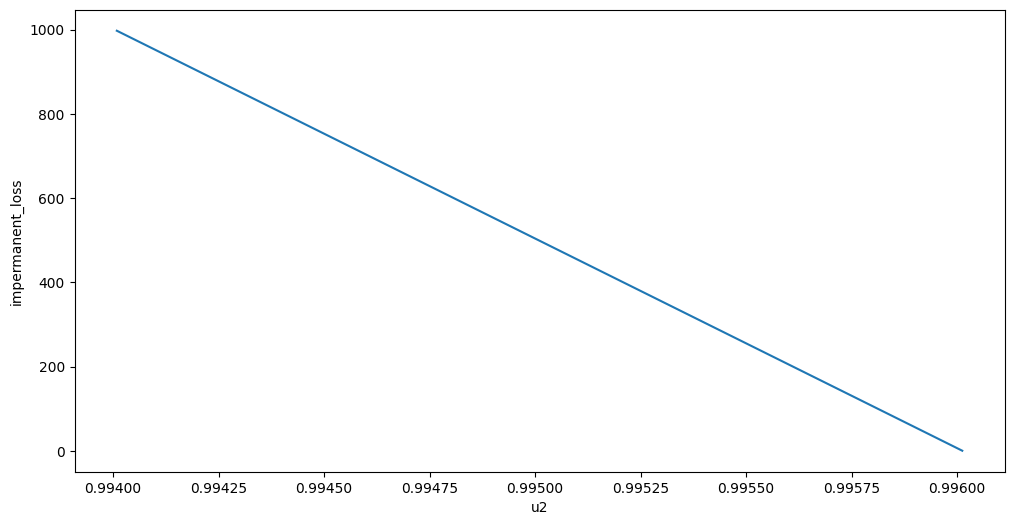

In [60]:
from pprint import pprint
numerator = 1-np.sqrt(u1 * (1-amm.f))
denominator = np.sqrt(u1/(1-amm.f)) - u1
print(f"numerator: {numerator} | denominator: {denominator}")
upper_bound = numerator/denominator
print(f"upper bound: {numerator/denominator}")
print(f"lower bound: {(1-amm.f)**2}")
lower_bound = (1-amm.f)**2
u2s = []
il = []

for u2 in np.linspace(lower_bound, upper_bound, 100):
    amm = AMM(fee=0.003, fee_pool=False)
    market = OracleSimulator(sigma=0.4, mu=0.06, start_price=500, steps=1000, spread=0, dt=1/(252*6.5*60*60))
    trader = Arbitrager(amm, market)

    u1 = 1.005
    market.pr *= u1
    swap_info1 = trader.swap()
    market.pr *= u2
    swap_info2 = trader.swap()
    u2s.append(u2)
    il.append(swap_info2['impermanent_loss'])

plt.figure(figsize=(12, 6))
plt.plot(u2s, il)
plt.xlabel('u2')
plt.ylabel('impermanent_loss')
plt.show()

/tmp/ipykernel_1690754/25465296.py:44: RuntimeWarning: invalid value encountered in double_scalars
  u2_upper = (np.sqrt(u1*(1-amm.f)) - 1) / (u1 - np.sqrt(u1/(1-amm.f)))


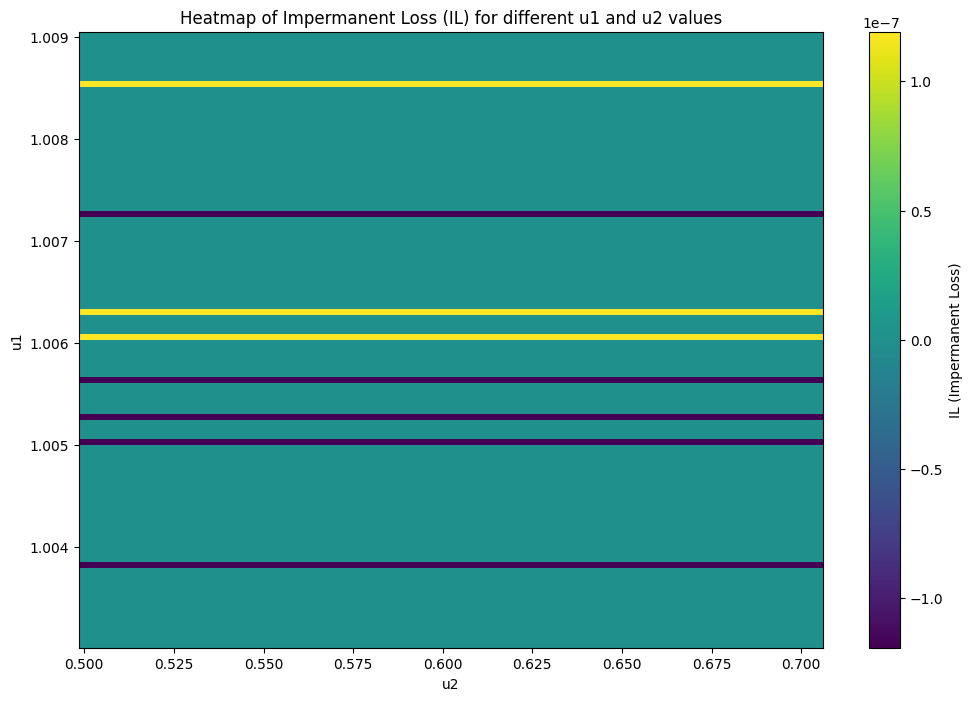

min il: -1.1920928955078125e-07
0.4985 0.7060453243241541 0.0


/tmp/ipykernel_1690754/25465296.py:100: RuntimeWarning: invalid value encountered in double_scalars
  u2_upper = (np.sqrt(u1*(1-amm.f)) - 1) / (u1 - np.sqrt(u1/(1-amm.f)))


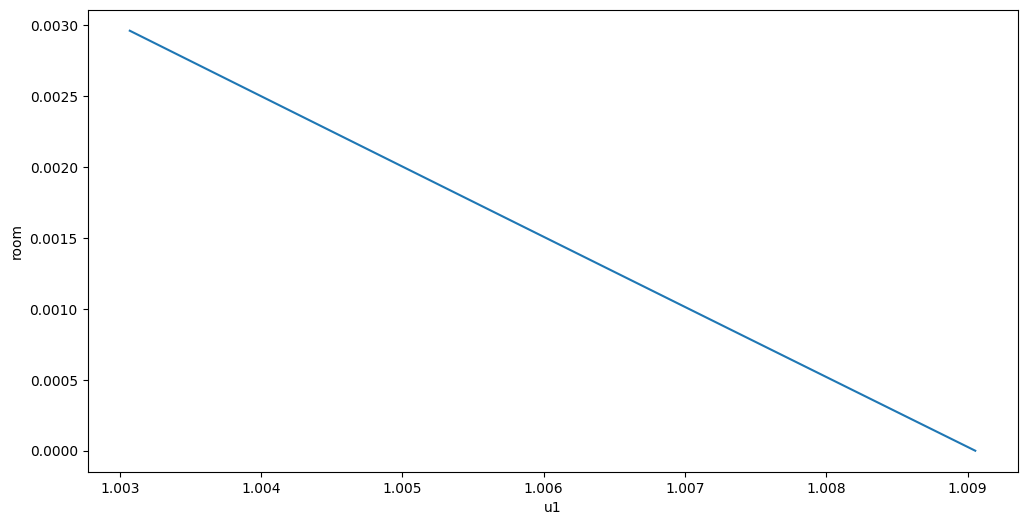

In [41]:
import os
import sys
import numpy as np
# add /home/shiftpub/Dynamic_AMM as a path
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(fee_pool=False)
trader = Arbitrager(amm, oracle)


amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
rooms = []
ils = []

amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid)
amm_asks.append(amm_ask)
market_bids.append(market_bid)
market_asks.append(market_ask)
u1_upper = 1/(1-amm.f)**3
u1_lower = 1/(1-amm.f)



# import numpy as np
# import matplotlib.pyplot as plt

# u1_values = np.linspace(u1_lower, 2, 100)


# # Create a 2D array to hold the 'il' values for each u1, u2 combination
# il_values = np.zeros((len(u1_values), len(u1_values)))

# # Compute 'il' for each pair of (u1, u2)
# for i, u1 in enumerate(u1_values):
#     u2_upper = (np.sqrt(u1*(1-amm.f)) - 1) / (u1 - np.sqrt(u1/(1-amm.f)))
#     u2_lower = (1/u1) * (1-amm.f)
#     # Define u1 and u2 ranges
#     u2_values = np.linspace(u2_lower, u2_upper, 100)
#     for j, u2 in enumerate(u2_values):
#         # Update oracle price as per u1 and u2
#         oracle.pr = oracle.pr * u1  # adjust oracle for current u1
#         trader.swap()  # perform trade operation
#         amm_ask, amm_bid = amm.get_price()
#         market_ask, market_bid = oracle.get_price()
#         u2 = (1/u1) * (1-amm.f)
#         oracle.pr = oracle.pr * u2  # adjust oracle for current u2
#         trader.swap()
#         il = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)

#         # Store il value
#         il_values[i, j] = il
#         trader.reset()

# # Plot the heatmap
# plt.figure(figsize=(12, 8))
# plt.imshow(il_values, extent=(u2_lower, u2_upper, u1_lower, u1_upper), origin='lower', aspect='auto', cmap='viridis')
# plt.colorbar(label='IL (Impermanent Loss)')
# plt.xlabel('u2')
# plt.ylabel('u1')
# plt.title('Heatmap of Impermanent Loss (IL) for different u1 and u2 values')
# plt.show()

# print(f"min il: {il_values.min()}")



# room = (u2_upper - u2_lower)
oracle.pr = oracle.pr * u1
trader.swap()
amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid)
amm_asks.append(amm_ask)
market_bids.append(market_bid)
market_asks.append(market_ask)
oracle.pr = oracle.pr * u2
trader.swap()
amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid)
amm_asks.append(amm_ask)
market_bids.append(market_bid)
market_asks.append(market_ask)
il = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)

# print(u2_lower, u2_upper, il)



for u1 in np.linspace(u1_lower, u1_upper, 100):
    u2_upper = (np.sqrt(u1*(1-amm.f)) - 1) / (u1 - np.sqrt(u1/(1-amm.f)))
    u2_lower = (1-amm.f)**2
    room = (u2_upper - u2_lower)
    rooms.append(room)

import matplotlib.pyplot as plt

# draw rooms
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(u1_lower, u1_upper, 100), rooms)
plt.xlabel('u1')
plt.ylabel('room')
plt.show()


# plt.figure(figsize=(12, 6))
# plt.scatter(np.arange(len(amm_bids)) - 0.01, amm_bids, label='amm_bid', color='blue')
# plt.scatter(np.arange(len(amm_asks)) + 0.01, amm_asks, label='amm_ask', color='red')
# # plt.scatter(np.arange(len(market_bids)) + np.random.uniform(-0.1, 0.1, len(market_bids)), market_bids, label='market_bid', color='green')
# plt.scatter(np.arange(len(market_asks)), market_asks, label='market_ask', color='orange')
# plt.legend()
# plt.show()


In [26]:
print(f"u1 : {u1} | u2 : {u2}")
print(f"amm_ask_0: {amm_asks[0]} | amm_bid_0: {amm_bids[0]}")
print(f"amm_ask_1: {amm_asks[1]} | amm_bid_1: {amm_bids[1]}")
print(f"amm_ask_2: {amm_asks[2]} | amm_bid_2: {amm_bids[2]}")
print(f"market_ask_0: {market_asks[0]} | market_bid_0: {market_bids[0]}")
print(f"market_ask_1: {market_asks[1]} | market_bid_1: {market_bids[1]}")
print(f"market_ask_2: {market_asks[2]} | market_bid_2: {market_bids[2]}")
il = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)
print(f"impermanent_loss: {il}")

u1 : 1.0090542712201236 | u2 : 0.9940089999999757
amm_ask_0: 1.0030090270812437 | amm_bid_0: 0.997
amm_ask_1: 1.0090542712201236 | amm_bid_1: 1.0030090270812437
amm_ask_2: 1.009054271220099 | amm_bid_2: 1.0030090270812193
market_ask_0: 1.0 | market_bid_0: 1.0
market_ask_1: 1.0090542712201236 | market_bid_1: 1.0090542712201236
market_ask_2: 1.0030090270812193 | market_bid_2: 1.0030090270812193
impermanent_loss: 1.1920928955078125e-07


In [ ]:
# draw a heatmap of the impermanent loss
import numpy as np

for u1 in 

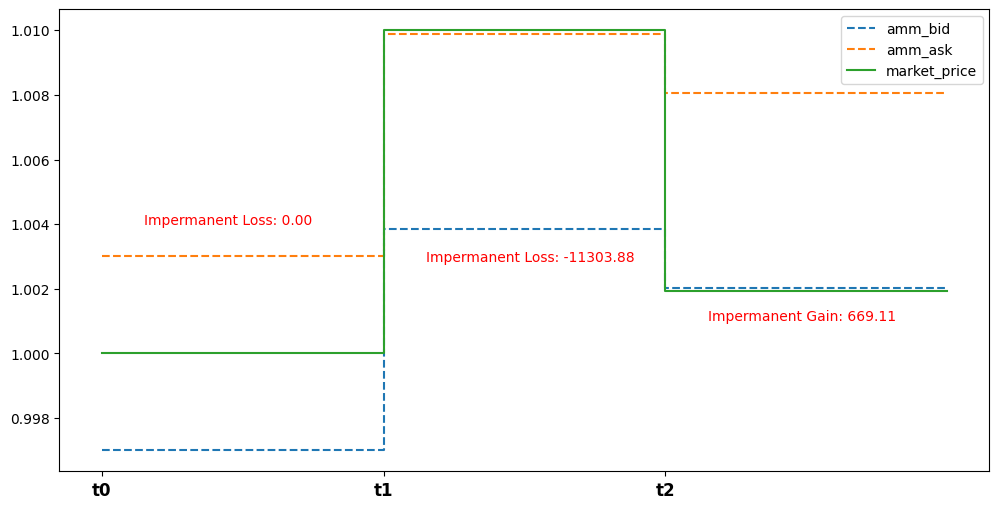

In [64]:
import os
import sys
import numpy as np
# add /home/shiftpub/Dynamic_AMM as a path
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager
import matplotlib.pyplot as plt

oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(fee_pool=False)
trader = Arbitrager(amm, oracle)


amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
rooms = []
ils = []

amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid)
amm_asks.append(amm_ask)
market_bids.append(market_bid)
market_asks.append(market_ask)
amm_bids.append(amm_bid)
amm_asks.append(amm_ask)
market_bids.append(market_bid)
market_asks.append(market_ask)
ils.append(0)
ils.append(0)
u1 = 1.01
oracle.pr = oracle.pr * u1
trader.swap()
amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid-0.0001)
amm_asks.append(amm_ask-0.0001)
market_bids.append(market_bid)
market_asks.append(market_ask)
ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))
oracle.pr = oracle.pr * 0.992
trader.swap()
amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid+0.0001)
amm_asks.append(amm_ask+0.0001)
market_bids.append(market_bid)
market_asks.append(market_ask)
ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))

plt.figure(figsize=(12, 6))
plt.step(range(len(amm_bids)), amm_bids, label='amm_bid', linestyle='--', where='pre')
plt.step(range(len(amm_asks)), amm_asks, label='amm_ask', linestyle='--', where='pre')
plt.step(range(len(market_bids)), market_bids, label='market_price', linestyle='-', where='pre')
# Set custom x-ticks and labels for 0, 1, and 2, and ignore others
plt.xticks([0, 1, 2], ["t0", "t1", "t2"])
# make font size bigger for ticks and bold
plt.xticks(fontsize=12, fontweight='bold')
# add anotation for impermanent loss

plt.annotate(f'Impermanent Loss: {ils[0]:.2f}', 
xy=(0.15, amm_bids[0]), 
xytext=(0.15, amm_asks[0] + 0.001),  # Adjust as needed
fontsize=10, color='red')

plt.annotate(f'Impermanent Loss: {ils[2]:.2f}', 
xy=(1.15, amm_bids[2]), 
xytext=(1.15, amm_bids[2] - 0.001),  # Adjust as needed
fontsize=10, color='red')

plt.annotate(f'Impermanent Gain: {ils[3]:.2f}', 
             xy=(2.15, amm_bids[3]), 
             xytext=(2.15, amm_bids[3] - 0.001),  # Adjust as needed
             fontsize=10, color='red')

# plt.plot(amm_bids, label='amm_bid', color='blue')
# plt.plot(amm_asks, label='amm_ask', color='red')
# plt.plot(market_bids, label='market_bid', color='green')
# plt.scatter(np.arange(len(amm_bids)) - 0.01, amm_bids, label='amm_bid', color='blue')
# plt.scatter(np.arange(len(amm_asks)) + 0.01, amm_asks, label='amm_ask', color='red')
# # plt.scatter(np.arange(len(market_bids)) + np.random.uniform(-0.1, 0.1, len(market_bids)), market_bids, label='market_bid', color='green')
# plt.scatter(np.arange(len(market_asks)), market_asks, label='market_ask', color='orange')
plt.legend()
plt.show()

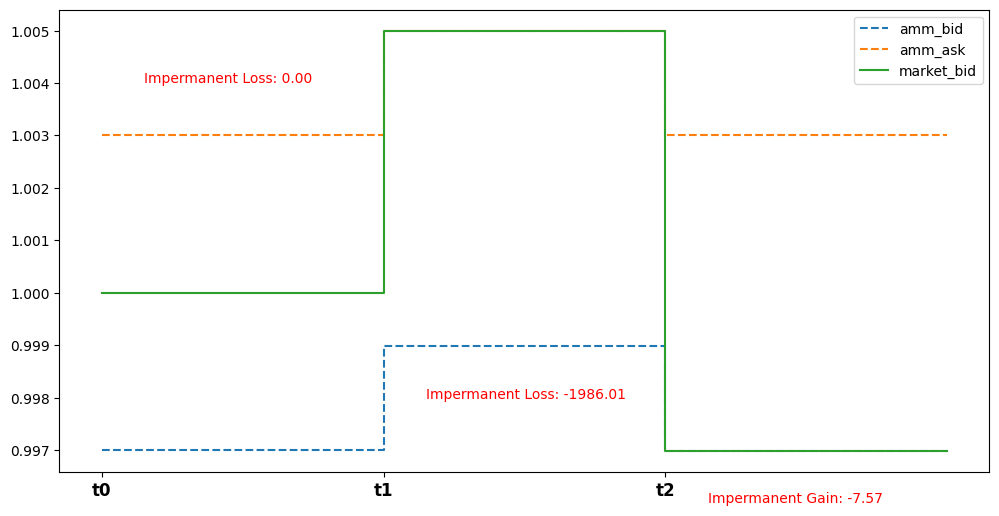

In [51]:
import os
import sys
import numpy as np
# add /home/shiftpub/Dynamic_AMM as a path
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager
import matplotlib.pyplot as plt

oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(fee_pool=False)
trader = Arbitrager(amm, oracle)


amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
rooms = []
ils = []

amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid)
amm_asks.append(amm_ask)
market_bids.append(market_bid)
market_asks.append(market_ask)
amm_bids.append(amm_bid)
amm_asks.append(amm_ask)
market_bids.append(market_bid)
market_asks.append(market_ask)
ils.append(0)
ils.append(0)
u1 = 1.005
oracle.pr = oracle.pr * u1
trader.swap()
amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid-0.000001)
amm_asks.append(amm_ask-0.000001)
market_bids.append(market_bid)
market_asks.append(market_ask)
ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))
# u2 = (np.sqrt(u1*(1-amm.f)) - 1) / (u1 - np.sqrt(u1/(1-amm.f)))
# u2 = 1/u1 * (1/(1-amm.f))
u2 = 1/u1 * (1-amm.f)
oracle.pr = oracle.pr * u2
trader.swap()
amm_ask, amm_bid = amm.get_price()
market_ask, market_bid = oracle.get_price()
amm_bids.append(amm_bid+0.000001)
amm_asks.append(amm_ask+0.000001)
market_bids.append(market_bid)
market_asks.append(market_ask)
ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))


plt.figure(figsize=(12, 6))
plt.step(range(len(amm_bids)), amm_bids, label='amm_bid', linestyle='--', where='pre')
plt.step(range(len(amm_asks)), amm_asks, label='amm_ask', linestyle='--', where='pre')
plt.step(range(len(market_bids)), market_bids, label='market_bid', linestyle='-', where='pre')
# Set custom x-ticks and labels for 0, 1, and 2, and ignore others
plt.xticks([0, 1, 2], ["t0", "t1", "t2"])
# make font size bigger for ticks and bold
plt.xticks(fontsize=12, fontweight='bold')
# add anotation for impermanent loss

plt.annotate(f'Impermanent Loss: {ils[0]:.2f}', 
xy=(0.15, amm_bids[0]), 
xytext=(0.15, amm_asks[0] + 0.001),  # Adjust as needed
fontsize=10, color='red')

plt.annotate(f'Impermanent Loss: {ils[2]:.2f}', 
xy=(1.15, amm_bids[2]), 
xytext=(1.15, amm_bids[2] - 0.001),  # Adjust as needed
fontsize=10, color='red')

plt.annotate(f'Impermanent Gain: {ils[3]:.2f}', 
             xy=(2.15, amm_bids[3]), 
             xytext=(2.15, amm_bids[3] - 0.001),  # Adjust as needed
             fontsize=10, color='red')
plt.legend()
plt.show()

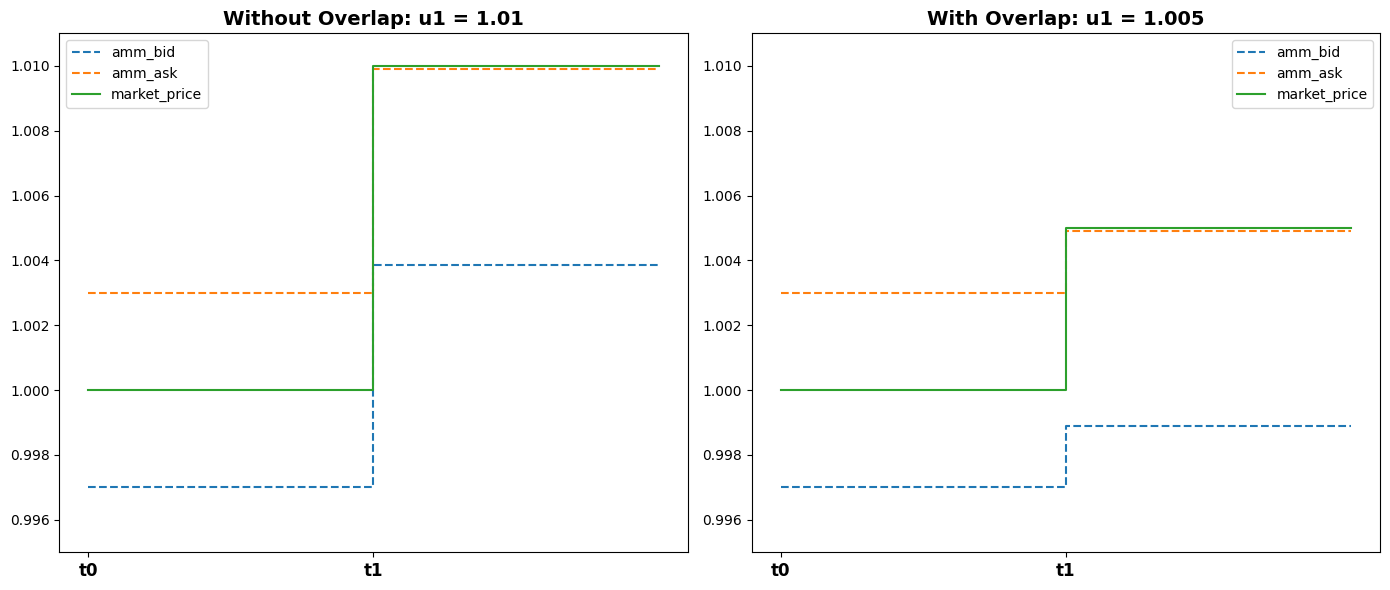

In [154]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add path for module import
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

def simulate_amm(u1):
    # Initialize Oracle, AMM, and Trader
    oracle = OracleSimulator(spread=0, sigma=1)
    amm = AMM(fee_pool=False)
    trader = Arbitrager(amm, oracle)

    # Track bids, asks, and market values
    amm_bids = []
    amm_asks = []
    market_bids = []
    market_asks = []
    ils = []

    # Initial prices
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.extend([amm_bid, amm_bid])
    amm_asks.extend([amm_ask, amm_ask])
    market_bids.extend([market_bid, market_bid])
    market_asks.extend([market_ask, market_ask])
    ils.extend([0, 0])

    # Step 1: Adjust market price by u1
    oracle.pr *= u1
    trader.swap()
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid - 0.0001)
    amm_asks.append(amm_ask - 0.0001)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))

    return amm_bids, amm_asks, market_bids, market_asks, ils

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot for u1 = 1.01
u1 = 1.01
amm_bids, amm_asks, market_bids, market_asks, ils = simulate_amm(u1)
axes[0].step(range(len(amm_bids)), amm_bids, label='amm_bid', linestyle='--', where='pre')
axes[0].step(range(len(amm_asks)), amm_asks, label='amm_ask', linestyle='--', where='pre')
axes[0].step(range(len(market_bids)), market_bids, label='market_price', linestyle='-', where='pre')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["t0", "t1"], fontsize=12, fontweight='bold')
axes[0].set_ylim(0.995, 1.011)
axes[0].legend()
axes[0].set_title("Without Overlap: u1 = 1.01", fontsize=14, fontweight='bold')

# Right subplot for u1 = 1.005
u1 = 1.005
amm_bids, amm_asks, market_bids, market_asks, ils = simulate_amm(u1)
axes[1].step(range(len(amm_bids)), amm_bids, label='amm_bid', linestyle='--', where='pre')
axes[1].step(range(len(amm_asks)), amm_asks, label='amm_ask', linestyle='--', where='pre')
axes[1].step(range(len(market_bids)), market_bids, label='market_price', linestyle='-', where='pre')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["t0", "t1"], fontsize=12, fontweight='bold')
axes[1].set_ylim(0.995, 1.011)
axes[1].legend()
axes[1].set_title("With Overlap: u1 = 1.005", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


impermanent_gains: {'IG': [-2007.2769774198532, -1979.666835308075, -1952.1790914535522, -1924.8137421607971, -1897.5707831382751, -1870.450210094452, -1843.4520193338394, -1816.5762065649033, -1789.8227679729462, -1763.1916992664337, -1736.6829962730408, -1710.2966549396515, -1684.0326716899872, -1657.8910419940948, -1631.8717617988586, -1605.9748272895813, -1580.200234055519, -1554.547978401184, -1529.018056154251, -1503.6104629039764, -1478.3251950740814, -1453.1622483730316, -1428.1216187477112, -1403.2033021450043, -1378.407294511795, -1353.7335916757584, -1329.182189822197, -1304.7530846595764, -1280.4462723731995, -1256.2617485523224, -1232.199509382248, -1208.2595508098602, -1184.4418686628342, -1160.746458888054, -1137.1733174324036, -1113.7224403619766, -1090.3938236236572, -1067.1874630451202, -1044.1033543348312, -1021.1414937973022, -998.3018771409988, -975.584500670433, -952.9893599748611, -930.5164510011673, -908.165769815445, -885.9373123645782, -863.8310747146606, -841

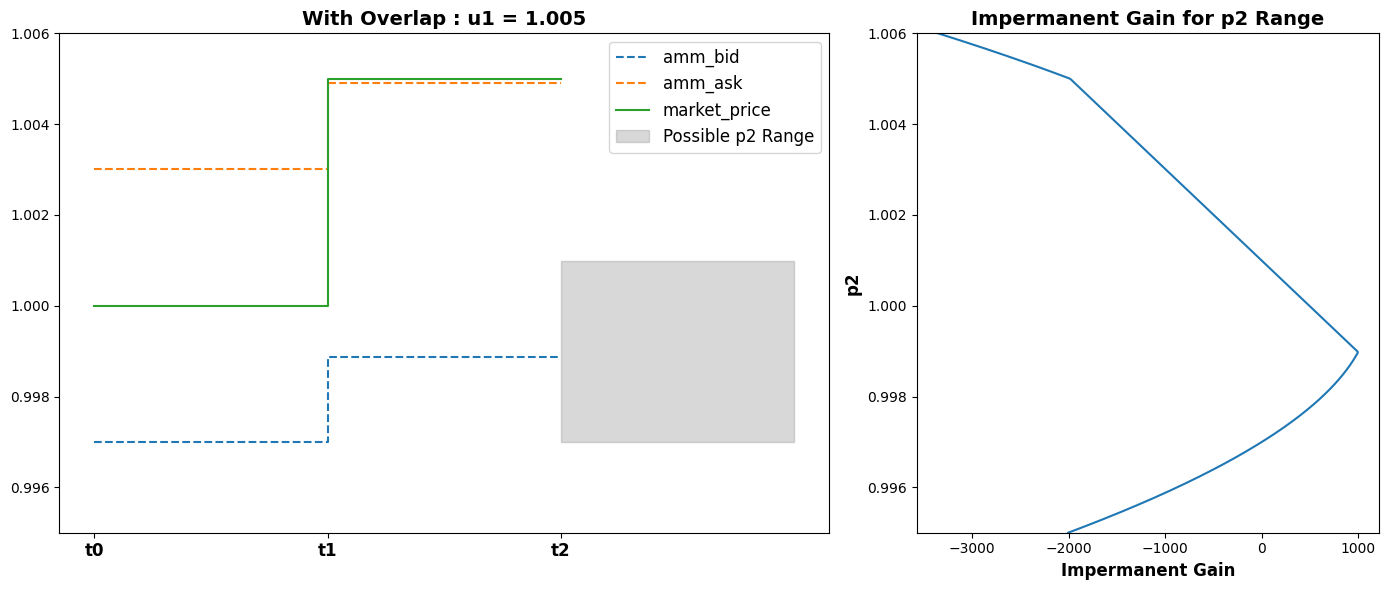

In [126]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add path for module import
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

# Initialize lists to store prices and impermanent loss
amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
ils = []


# Initialize the AMM, Oracle, and Trader
oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(fee_pool=False)
trader = Arbitrager(amm, oracle)
# Calculate range for p2 based on the given formula
fee_rate = amm.f
u1 = 1.005
u2_lower = (1 - fee_rate) / u1
u2_upper = (np.sqrt(u1 * (1 - fee_rate)) - 1) / (u1 - np.sqrt(u1 / (1 - fee_rate)))
p2_upper = u1 * u2_upper
p2_lower = u1 * u2_lower
p2_values = np.linspace(p2_lower, p2_upper, 500)  # Sample 50 points within the p2 range

# Calculate impermanent gain (IG) for a range of p2 values
# u2_values = np.linspace(u2_lower, u2_upper, 500)  # Sample 50 points within the p2 range
u2_values = np.linspace(0.995/u1, 1.006/u1, 500)  # Sample 50 points within the p2 range
impermanent_gains = {
    'IG': [],
    'p2': []
}

for u2 in u2_values:
    oracle = OracleSimulator(spread=0, sigma=1)
    amm = AMM(fee_pool=False)
    trader = Arbitrager(amm, oracle)
    # Record initial prices and calculate initial impermanent loss
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)

    # Step 1: Market price changes by u1
    u1 = 1.005
    oracle.pr *= u1
    trader.swap()
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid - 0.0001)
    amm_asks.append(amm_ask - 0.0001)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))

    oracle.pr *= u2
    trader.swap()
    # Calculate IG based on the provided formula
    IG = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)
    p2 = u1 * u2
    impermanent_gains['IG'].append(IG)
    impermanent_gains['p2'].append(p2)
print(f"impermanent_gains: {impermanent_gains}")
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 0.6]})

# Left subplot with shaded area for valid p2 range
amm_bids[3] = None
amm_asks[3] = None
market_bids[3] = None
plt.sca(axes[0])
plt.step(range(4), amm_bids[:4], label='amm_bid', linestyle='--', where='pre')
plt.step(range(4), amm_asks[:4], label='amm_ask', linestyle='--', where='pre')
plt.step(range(4), market_bids[:4], label='market_price', linestyle='-', where='pre')

# Shade the area for valid p2 range
axes[0].fill_between([2, 3], p2_lower, p2_upper, color='gray', alpha=0.3, label='Possible p2 Range')
plt.xticks([0, 1, 2], ["t0", "t1", "t2"], fontsize=12, fontweight='bold')
# set y limit from 0.99 to 1.06
plt.ylim(0.995, 1.006)
axes[0].legend(fontsize=12)
axes[0].set_title("With Overlap : u1 = 1.005", fontsize=14, fontweight='bold')

# Right subplot: bar chart of impermanent gains for each p2
plt.sca(axes[1])
# u2_values = np.linspace(0.995/u1, 1.006/u1, 500)  # Sample 50 points within the p2 range
axes[1].plot(impermanent_gains['IG'], impermanent_gains['p2'])
axes[1].set_xlabel("Impermanent Gain", fontsize=12, fontweight='bold')
axes[1].set_ylabel("p2", fontsize=12, fontweight='bold')
plt.ylim(0.995, 1.006)
axes[1].set_title("Impermanent Gain for p2 Range", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


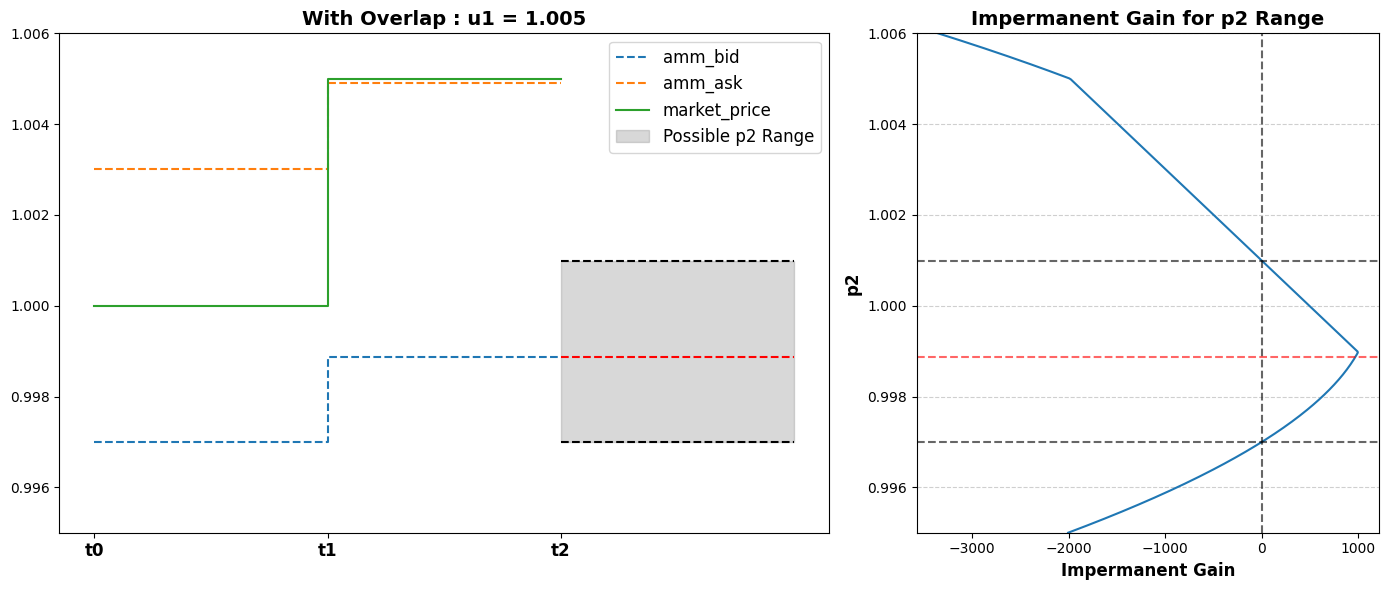

In [23]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add path for module import
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

# Initialize lists to store prices and impermanent gain data
amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
ils = []

# Initialize the AMM, Oracle, and Trader
oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(fee_pool=False)
trader = Arbitrager(amm, oracle)

# Parameters
fee_rate = amm.f
u1 = 1.005
u2_lower = (1 - fee_rate) / u1
# u2_upper = (np.sqrt(u1 * (1 - fee_rate)) - 1) / (u1 - np.sqrt(u1 / (1 - fee_rate)))
u2_upper = np.sqrt((1-amm.f)/u1)
p2_lower = u1 * u2_lower
p2_upper = u1 * u2_upper
u2_values = np.linspace(0.995 / u1, 1.006 / u1, 500)

# Calculate impermanent gain (IG) for a range of u2 values
impermanent_gains = {
    'IG': [],
    'p2': []
}

for u2 in u2_values:
    oracle = OracleSimulator(spread=0, sigma=1)
    amm = AMM(fee_pool=False)
    trader = Arbitrager(amm, oracle)
    # Record initial prices and calculate initial impermanent loss
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)

    # Step 1: Market price changes by u1
    u1 = 1.005
    oracle.pr *= u1
    trader.swap()
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid - 0.0001)
    amm_asks.append(amm_ask - 0.0001)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))

    oracle.pr *= u2
    trader.swap()
    # Calculate IG based on the provided formula
    IG = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)
    p2 = u1 * u2
    impermanent_gains['IG'].append(IG)
    impermanent_gains['p2'].append(p2)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 0.6]})

# Left subplot with shaded area for valid p2 range
amm_bids[3] = None
amm_asks[3] = None
market_bids[3] = None
plt.sca(axes[0])
plt.step(range(4), amm_bids[:4], label='amm_bid', linestyle='--', where='pre')
plt.step(range(4), amm_asks[:4], label='amm_ask', linestyle='--', where='pre')
plt.step(range(4), market_bids[:4], label='market_price', linestyle='-', where='pre')

# Shade the area for valid p2 range
axes[0].fill_between([2, 3], p2_lower, p2_upper, color='gray', alpha=0.3, label='Possible p2 Range')
# Add dashed boundary lines for the shaded area
axes[0].hlines(p2_lower, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)
axes[0].hlines(p2_upper, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)
axes[0].hlines(amm_bids[2], 2, 3, colors='red', linestyles='dashed', linewidth=1.5)

axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(["t0", "t1", "t2"], fontsize=12, fontweight='bold')
plt.ylim(0.995, 1.006)
axes[0].legend(fontsize=12)
axes[0].set_title("With Overlap : u1 = 1.005", fontsize=14, fontweight='bold')

# Right subplot: bar chart of impermanent gains for each p2
plt.sca(axes[1])
# Color code positive and negative impermanent gains
axes[1].plot( impermanent_gains['IG'], impermanent_gains['p2'])
axes[1].set_xlabel("Impermanent Gain", fontsize=12, fontweight='bold')
axes[1].set_ylabel("p2", fontsize=12, fontweight='bold')
plt.ylim(0.995, 1.006)
axes[1].set_title("Impermanent Gain for p2 Range", fontsize=14, fontweight='bold')
# add vertical line for 0 impermanent gain and two horizontal lines for p2_upper and p2_lower
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_lower, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_upper, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=amm_bids[2], color='red', linestyle='--', alpha=0.6)

axes[1].grid(axis='y', linestyle='--', alpha=0.6)  # Add gridlines for alignment

plt.tight_layout()
plt.show()


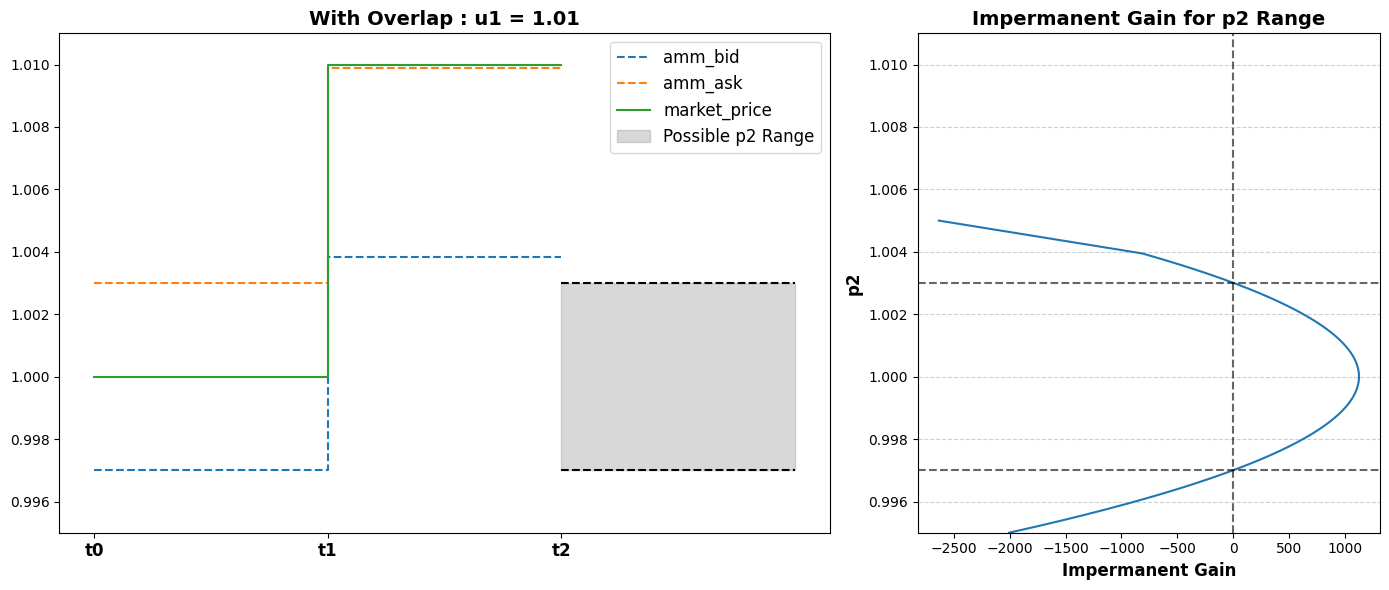

In [145]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add path for module import
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

# Initialize lists to store prices and impermanent gain data
amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
ils = []

# Initialize the AMM, Oracle, and Trader
oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(fee_pool=False)
trader = Arbitrager(amm, oracle)

# Parameters
fee_rate = amm.f
u1 = 1.01
u2_lower = (1 - fee_rate) / u1
# u2_upper = (np.sqrt(u1 * (1 - fee_rate)) - 1) / (u1 - np.sqrt(u1 / (1 - fee_rate)))
u2_upper = 1/(u1 * (1 - fee_rate))
p2_lower = u1 * u2_lower
p2_upper = u1 * u2_upper
u2_values = np.linspace(0.995 / u1, 1.005 / u1, 500)

# Calculate impermanent gain (IG) for a range of u2 values
impermanent_gains = {
    'IG': [],
    'p2': []
}

for u2 in u2_values:
    oracle = OracleSimulator(spread=0, sigma=1)
    amm = AMM(fee_pool=False)
    trader = Arbitrager(amm, oracle)
    # Record initial prices and calculate initial impermanent loss
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)

    # Step 1: Market price changes by u1
    u1 = 1.01
    oracle.pr *= u1
    trader.swap()
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid - 0.0001)
    amm_asks.append(amm_ask - 0.0001)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))

    oracle.pr *= u2
    trader.swap()
    # Calculate IG based on the provided formula
    IG = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)
    p2 = u1 * u2
    impermanent_gains['IG'].append(IG)
    impermanent_gains['p2'].append(p2)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 0.6]})

# Left subplot with shaded area for valid p2 range
amm_bids[3] = None
amm_asks[3] = None
market_bids[3] = None
plt.sca(axes[0])
plt.step(range(4), amm_bids[:4], label='amm_bid', linestyle='--', where='pre')
plt.step(range(4), amm_asks[:4], label='amm_ask', linestyle='--', where='pre')
plt.step(range(4), market_bids[:4], label='market_price', linestyle='-', where='pre')

# Shade the area for valid p2 range
axes[0].fill_between([2, 3], p2_lower, p2_upper, color='gray', alpha=0.3, label='Possible p2 Range')
# Add dashed boundary lines for the shaded area
axes[0].hlines(p2_lower, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)
axes[0].hlines(p2_upper, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)

axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(["t0", "t1", "t2"], fontsize=12, fontweight='bold')
plt.ylim(0.995, 1.011)
axes[0].legend(fontsize=12)
axes[0].set_title("Without Overlap : u1 = 1.01", fontsize=14, fontweight='bold')

# Right subplot: bar chart of impermanent gains for each p2
plt.sca(axes[1])
# Color code positive and negative impermanent gains
axes[1].plot( impermanent_gains['IG'], impermanent_gains['p2'])
axes[1].set_xlabel("Impermanent Gain", fontsize=12, fontweight='bold')
axes[1].set_ylabel("p2", fontsize=12, fontweight='bold')
plt.ylim(0.995, 1.011)
axes[1].set_title("Impermanent Gain for p2 Range", fontsize=14, fontweight='bold')
# add vertical line for 0 impermanent gain and two horizontal lines for p2_upper and p2_lower
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_lower, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_upper, color='black', linestyle='--', alpha=0.6)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)  # Add gridlines for alignment

plt.tight_layout()
plt.show()

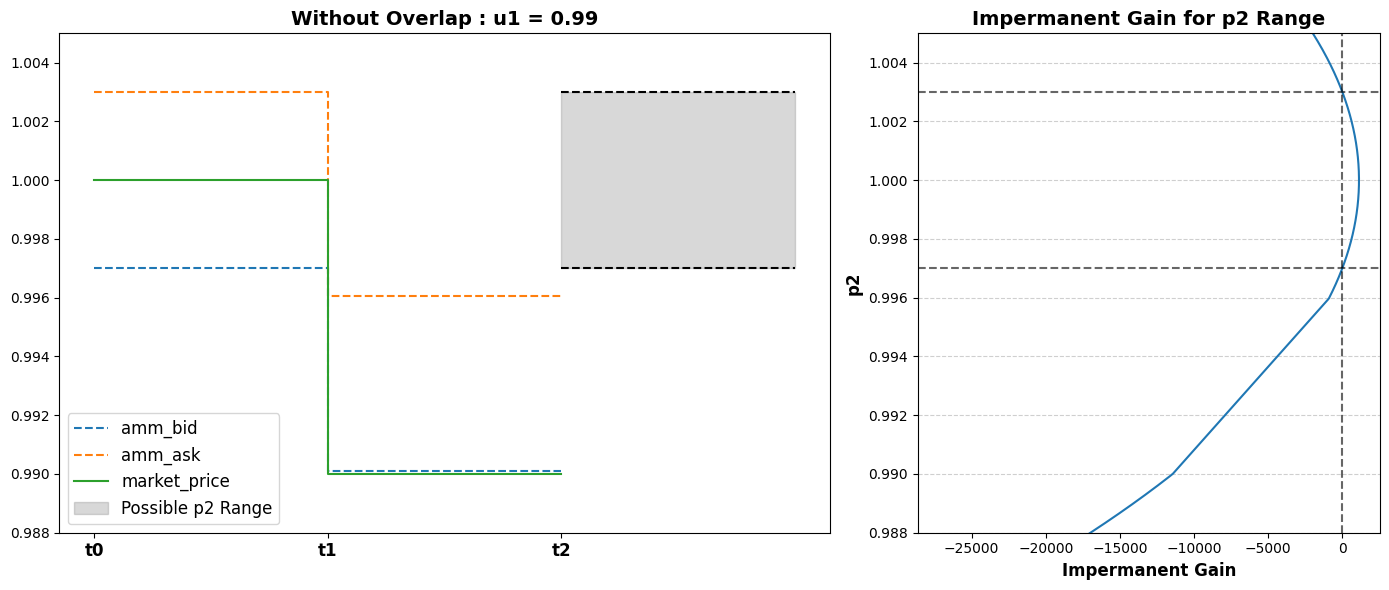

In [35]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add path for module import
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

# Initialize lists to store prices and impermanent gain data
amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
ils = []

# Initialize the AMM, Oracle, and Trader
oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(fee_pool=False)
trader = Arbitrager(amm, oracle)

# Parameters
fee_rate = amm.f
u1 = 0.99
u2_lower = (1 - fee_rate) / u1
# u2_upper = (np.sqrt(u1 * (1 - fee_rate)) - 1) / (u1 - np.sqrt(u1 / (1 - fee_rate)))
u2_upper = 1/(u1*(1 - fee_rate))
p2_lower = u1 * u2_lower
p2_upper = u1 * u2_upper
u2_values = np.linspace(0.985 / u1, 1.005 / u1, 500)

# Calculate impermanent gain (IG) for a range of u2 values
impermanent_gains = {
    'IG': [],
    'p2': []
}

for u2 in u2_values:
    oracle = OracleSimulator(spread=0, sigma=1)
    amm = AMM(fee_pool=False)
    trader = Arbitrager(amm, oracle)
    # Record initial prices and calculate initial impermanent loss
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)

    # Step 1: Market price changes by u1
    u1 = 0.99
    oracle.pr *= u1
    trader.swap()
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid + 0.0001)
    amm_asks.append(amm_ask + 0.0001)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))

    oracle.pr *= u2
    trader.swap()
    # Calculate IG based on the provided formula
    IG = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)
    p2 = u1 * u2
    impermanent_gains['IG'].append(IG)
    impermanent_gains['p2'].append(p2)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 0.6]})

# Left subplot with shaded area for valid p2 range
amm_bids[3] = None
amm_asks[3] = None
market_bids[3] = None
plt.sca(axes[0])
plt.step(range(4), amm_bids[:4], label='amm_bid', linestyle='--', where='pre')
plt.step(range(4), amm_asks[:4], label='amm_ask', linestyle='--', where='pre')
plt.step(range(4), market_bids[:4], label='market_price', linestyle='-', where='pre')

# Shade the area for valid p2 range
axes[0].fill_between([2, 3], p2_lower, p2_upper, color='gray', alpha=0.3, label='Possible p2 Range')
# Add dashed boundary lines for the shaded area
axes[0].hlines(p2_lower, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)
axes[0].hlines(p2_upper, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)

axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(["t0", "t1", "t2"], fontsize=12, fontweight='bold')
axes[0].set_ylim(0.988, 1.004)
plt.ylim(0.988, 1.005)
axes[0].legend(fontsize=12)
axes[0].set_title("Without Overlap : u1 = 0.99", fontsize=14, fontweight='bold')

# Right subplot: bar chart of impermanent gains for each p2
plt.sca(axes[1])
# Color code positive and negative impermanent gains
axes[1].plot( impermanent_gains['IG'], impermanent_gains['p2'])
axes[1].set_xlabel("Impermanent Gain", fontsize=12, fontweight='bold')
axes[1].set_ylabel("p2", fontsize=12, fontweight='bold')
axes[1].set_ylim(0.988, 1.005)
# plt.ylim(0.988, 1.004)
axes[1].set_title("Impermanent Gain for p2 Range", fontsize=14, fontweight='bold')
# add vertical line for 0 impermanent gain and two horizontal lines for p2_upper and p2_lower
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_lower, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_upper, color='black', linestyle='--', alpha=0.6)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)  # Add gridlines for alignment

plt.tight_layout()
plt.show()

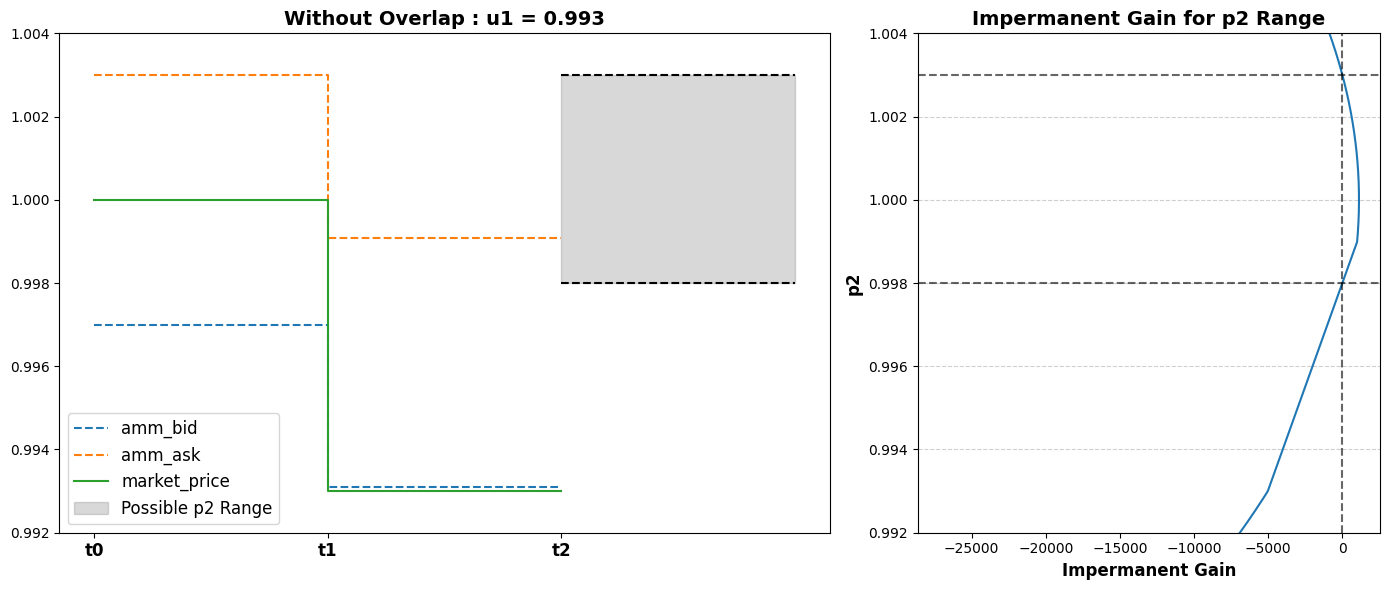

In [40]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add path for module import
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

# Initialize lists to store prices and impermanent gain data
amm_bids = []
amm_asks = []
market_bids = []
market_asks = []
ils = []

# Initialize the AMM, Oracle, and Trader
oracle = OracleSimulator(spread=0, sigma=1)
amm = AMM(fee_pool=False)
trader = Arbitrager(amm, oracle)

# Parameters
fee_rate = amm.f
u1 = 0.993
u2_lower = 1/np.sqrt(u1 * (1 - fee_rate))
# u2_upper = (np.sqrt(u1 * (1 - fee_rate)) - 1) / (u1 - np.sqrt(u1 / (1 - fee_rate)))
u2_upper = 1/(u1*(1 - fee_rate))
p2_lower = u1 * u2_lower
p2_upper = u1 * u2_upper
u2_values = np.linspace(0.985 / u1, 1.005 / u1, 500)

# Calculate impermanent gain (IG) for a range of u2 values
impermanent_gains = {
    'IG': [],
    'p2': []
}

for u2 in u2_values:
    oracle = OracleSimulator(spread=0, sigma=1)
    amm = AMM(fee_pool=False)
    trader = Arbitrager(amm, oracle)
    # Record initial prices and calculate initial impermanent loss
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append(0)

    # Step 1: Market price changes by u1
    oracle.pr *= u1
    trader.swap()
    amm_ask, amm_bid = amm.get_price()
    market_ask, market_bid = oracle.get_price()
    amm_bids.append(amm_bid + 0.0001)
    amm_asks.append(amm_ask + 0.0001)
    market_bids.append(market_bid)
    market_asks.append(market_ask)
    ils.append((oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls))

    oracle.pr *= u2
    trader.swap()
    # Calculate IG based on the provided formula
    IG = (oracle.pr * amm.lr + oracle.ps * amm.ls) - (oracle.pr * amm.initial_lr + oracle.ps * amm.initial_ls)
    p2 = u1 * u2
    impermanent_gains['IG'].append(IG)
    impermanent_gains['p2'].append(p2)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 0.6]})

# Left subplot with shaded area for valid p2 range
amm_bids[3] = None
amm_asks[3] = None
market_bids[3] = None
plt.sca(axes[0])
plt.step(range(4), amm_bids[:4], label='amm_bid', linestyle='--', where='pre')
plt.step(range(4), amm_asks[:4], label='amm_ask', linestyle='--', where='pre')
plt.step(range(4), market_bids[:4], label='market_price', linestyle='-', where='pre')

# Shade the area for valid p2 range
axes[0].fill_between([2, 3], p2_lower, p2_upper, color='gray', alpha=0.3, label='Possible p2 Range')
# Add dashed boundary lines for the shaded area
axes[0].hlines(p2_lower, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)
axes[0].hlines(p2_upper, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)

axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(["t0", "t1", "t2"], fontsize=12, fontweight='bold')
axes[0].set_ylim(0.992, 1.004)
axes[0].legend(fontsize=12)
axes[0].set_title("Without Overlap : u1 = 0.993", fontsize=14, fontweight='bold')

# Right subplot: bar chart of impermanent gains for each p2
plt.sca(axes[1])
# Color code positive and negative impermanent gains
axes[1].plot( impermanent_gains['IG'], impermanent_gains['p2'])
axes[1].set_xlabel("Impermanent Gain", fontsize=12, fontweight='bold')
axes[1].set_ylabel("p2", fontsize=12, fontweight='bold')
axes[1].set_ylim(0.992, 1.004)
axes[1].set_title("Impermanent Gain for p2 Range", fontsize=14, fontweight='bold')
# add vertical line for 0 impermanent gain and two horizontal lines for p2_upper and p2_lower
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_lower, color='black', linestyle='--', alpha=0.6)
axes[1].axhline(y=p2_upper, color='black', linestyle='--', alpha=0.6)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)  # Add gridlines for alignment

plt.tight_layout()
plt.show()

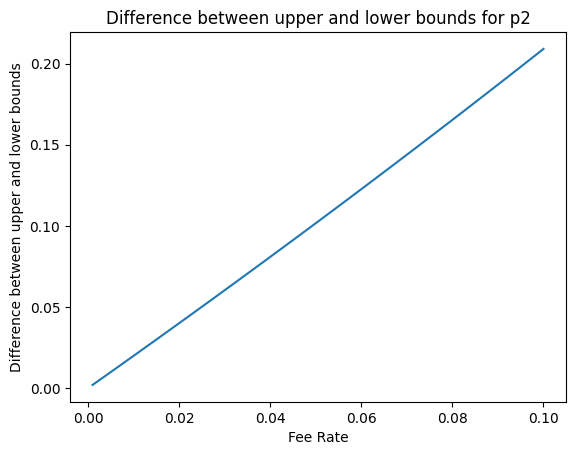

In [34]:
u1 = 1.01
f = 0.003
lower = (1-f)/u1
upper = 1/(u1*(1-f))
diffs = []
for f in np.linspace(0.001, 0.1, 100):
    lower = (1-f)/u1
    upper = 1/(u1*(1-f))
    diffs.append(upper - lower)

plt.plot(np.linspace(0.001, 0.1, 100), diffs)
plt.xlabel("Fee Rate")
plt.ylabel("Difference between upper and lower bounds")
plt.title("Difference between upper and lower bounds for p2")
plt.show()


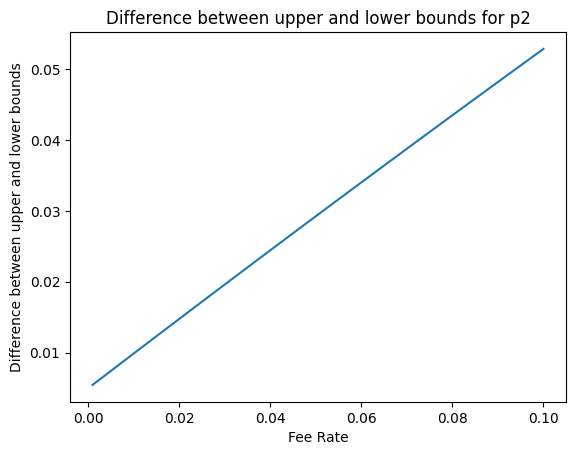

In [33]:
u1 = 1.01
f = 0.003
lower = (1-f)/u1
upper = np.sqrt((1-f)/u1)
diffs = []
for f in np.linspace(0.001, 0.1, 100):
    lower = (1-f)/u1
    upper = np.sqrt((1-f)/u1)
    diffs.append(upper - lower)

plt.plot(np.linspace(0.001, 0.1, 100), diffs)
plt.xlabel("Fee Rate")
plt.ylabel("Difference between upper and lower bounds")
plt.title("Difference between upper and lower bounds for p2")
plt.show()
